Ví dụ 1: Chúng ta vẫn bắt đầu với một ví dụ trên dữ liệu nhân tạo, tương tự như phần HARD MARGIN. Trước hết ta tạo một bộ dữ liệu có 200 mẫu (N=200) phân đều vào 02 lớp – mỗi lớp 100 phần tử. Mỗi mẫu có 2 chiều (d=2).


Cách 1. Tự xây dựng các bước giải bài toán ràng buộc: Phương pháp giải bài toán Lagrange đối ngẫu g(λ) để tìm λ, sau đó thay vào tính w, w0 (bám theo công thức được xây dựng trong phần lý thuyết)


In [1]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages


means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)


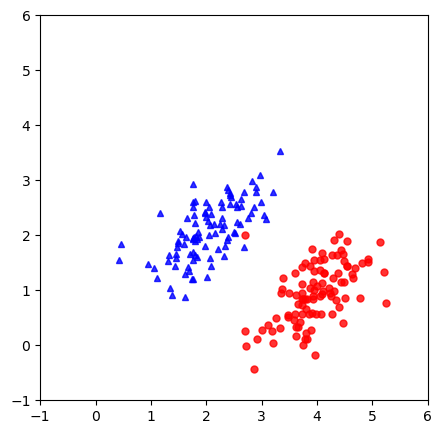

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()


In [3]:
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X.T, y.ravel())

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

In [4]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)


lambda = 
 [[8.49521168e-09 2.28019770e-08 5.20318603e-08 1.00362028e-08
  5.72230161e-09 4.03665689e-09 9.49322648e-09 9.66963407e-09
  5.87872821e-09 9.97869323e-09 3.38295949e-08 8.65612107e+01
  8.96678954e-09 3.95233167e-09 5.07686752e-09 3.33356397e-09
  2.81824209e+01 3.70532604e-09 4.21582769e-09 5.90903774e-09
  5.85241969e-09 3.65211347e-09 1.01611034e-08 2.75569113e-08
  3.64212583e-08 4.82977104e-09 4.46937814e-09 5.60793255e-09
  3.86694829e-09 3.69067251e-09 4.24754317e-09 1.27718916e-08
  4.37347243e-09 9.52015181e-09 4.11498756e-09 6.35147917e-09
  1.08517578e-07 3.09524028e-09 2.95135117e-09 1.09162746e-08
  2.07909371e-08 1.06429323e-08 3.91210618e-09 3.57013492e-09
  2.23388200e-08 3.19154757e-08 3.61074960e-09 5.35570952e-09
  3.37238889e-09 4.22246772e-08 1.25193204e-08 6.09783808e-09
  4.12675055e-09 5.30308638e-09 3.20345666e-08 7.32305964e-09
  2.48972727e-08 2.39828854e-08 1.18875284e-08 2.90249843e-08
  4.80431490e-09 9.80642912e-09 2.09423738e-08 1.26320117e-

In [5]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[:, M]
XM = X[:, M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print('w_dual = ', w_dual.T)
print('b_dual = ', b_dual)
w = w_dual 

w_dual =  [[-1.7209464   1.36773208]]
b_dual =  3.157639627752344


Cách 2. Xây dựng phương pháp giải bài toán tối ưu không ràng buộc

In [6]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data


Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C


def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
        .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias


def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g


eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g


w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)


Gradient different: 0.000000


In [7]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print('w_hinge = ', w_hinge.T)
print('b_hinge = ', b_hinge)

iter 1 cost: 268.172459
iter 10001 cost: 2.291049
iter 20001 cost: 2.286196
iter 30001 cost: 2.282661
iter 40001 cost: 2.279391
iter 50001 cost: 2.275553
iter 60001 cost: 2.272514
iter 70001 cost: 2.272747
iter 80001 cost: 2.286520
iter 90001 cost: 2.272603
w_hinge =  [[-1.70182769  1.37533109]]
b_hinge =  [3.08342659]


Bài tập thực hành 1: Sử dụng bộ số w và b đã tìm được để dự đoán phân lớp y của một điểm dữ liệu mới. Sau đó tính độ chính xác của thuật toán trên tập dữ liệu đã cho.# 

In [8]:
def predict(X, w, b):
    return np.sign(w.T.dot(X) + b)

from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_sklearn = predict(X, w_sklearn, b_sklearn)
print('Accuracy with sklearn = ', accuracy_score(y.ravel(), y_pred_sklearn.ravel()))
print('Confusion matrix with sklearn = \n', confusion_matrix(y.ravel(), y_pred_sklearn.ravel()))

y_pred_dual = predict(X, w_dual, b_dual)
print('Accuracy with dual = ', np.mean(y_pred_dual.ravel() == y.ravel()))
print('Confusion matrix with dual = \n', confusion_matrix(y.ravel(), y_pred_dual.ravel()))

y_pred_hinge = predict(X, w_hinge, b_hinge)
print('Accuracy with hinge= ', np.mean(y_pred_hinge.ravel() == y.ravel()))
print('Confusion matrix with hinge = \n', confusion_matrix(y.ravel(), y_pred_hinge.ravel()))

Accuracy with sklearn =  0.995
Confusion matrix with sklearn = 
 [[ 99   1]
 [  0 100]]
Accuracy with dual =  0.995
Confusion matrix with dual = 
 [[ 99   1]
 [  0 100]]
Accuracy with hinge=  0.995
Confusion matrix with hinge = 
 [[ 99   1]
 [  0 100]]


Cách 3. Sử dụng thư viện: 

In [9]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”, 
# if C is large enough, method is near to hard margin
clf.fit(X1, y1) 


w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)


w =  [[-1.7210582   1.36767249]]
b =  [3.15807685]


Bài tập thực hành 2:

In [10]:
from sklearn import datasets

cancer_data = datasets.load_breast_cancer()

# show to test record 5th
print(cancer_data.data[5])

print(cancer_data.data.shape)
#target set
print(cancer_data.target)

from sklearn.model_selection import train_test_split

cancer_data = datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer_data.data,cancer_data.target,test_size=0.3,random_state=109)

from sklearn import svm

clf = svm.SVC(kernel='linear') # Linear Kernel

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

[1.245e+01 1.570e+01 8.257e+01 4.771e+02 1.278e-01 1.700e-01 1.578e-01
 8.089e-02 2.087e-01 7.613e-02 3.345e-01 8.902e-01 2.217e+00 2.719e+01
 7.510e-03 3.345e-02 3.672e-02 1.137e-02 2.165e-02 5.082e-03 1.547e+01
 2.375e+01 1.034e+02 7.416e+02 1.791e-01 5.249e-01 5.355e-01 1.741e-01
 3.985e-01 1.244e-01]
(569, 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 

Ví dụ 2 (Bài tập tự giải)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.7936507936507936
[[21  7]
 [ 6 29]]
              precision    recall  f1-score   support

          -1       0.78      0.75      0.76        28
           1       0.81      0.83      0.82        35

    accuracy                           0.79        63
   macro avg

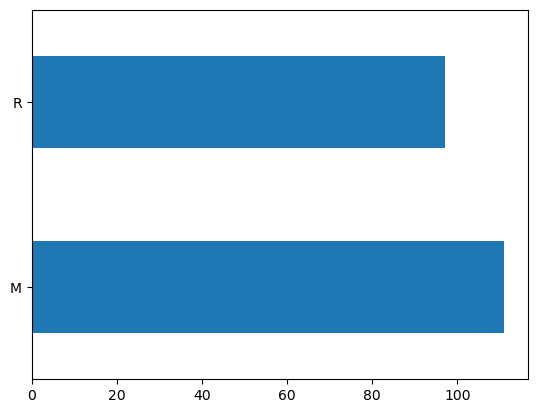

In [12]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

main_df = pd.read_csv('C:\\Users\\TGDD\\Desktop\\học máy\\Support Vector Machine - Soft Margin\\sonar.all-data.csv', header=None)
main_df
main_df[60].value_counts().plot(kind='barh')
y_df = main_df[60]
targes_label = {'M': 1, 'R': -1}
targes_df = [targes_label[item] for item in y_df]
print(targes_df)

inputs_df = main_df.drop(60, axis=1)

x0 = np.ones((inputs_df.shape[0], 1))
X = np.concatenate((x0, inputs_df), axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, targes_df, test_size=0.3, random_state=42)

from sklearn import svm

clf = svm.SVC(kernel='linear')  # Linear Kernel

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Ví dụ 3 (Bài tập tự giải): Lọc thư rác

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:\\Users\\TGDD\\Desktop\\học máy\\Support Vector Machine - Soft Margin\\spambase.data', header=None)

# chia dữ liệu thành 2 phần: dữ liệu đầu vào X và dữ liệu đầu ra y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# chia dữ liệu thành 2 phần: dữ liệu huấn luyện và dữ liệu kiểm tra
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# huấn luyện mô hình
from sklearn.svm import SVC

svm = SVC(kernel='linear', C = 1.0)
svm.fit(X_train, y_train)

# dự đoán kết quả
y_pred = svm.predict(X_test)
print(y_pred.shape)

# đánh giá mô hình
from sklearn.metrics import accuracy_score, confusion_matrix

print('Accuracy = ', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

(1381,)
Accuracy =  0.9370021723388848
[[785  40]
 [ 47 509]]
